In [4]:
import torch
from tqdm import trange
from datasets.synthetic.quadratic_potential import ConvexQuadraticPotential
from datasets import BananaDataset

tensor_parameters = {}
dataset = BananaDataset(tensor_parameters)

training_trace = []
quadratic_potential = ConvexQuadraticPotential(
    number_of_functions=100,
    response_size=2,
    covariate_size=1,
    epsilon=1e-3,
)
quadratic_potential_optimizer = torch.optim.AdamW(params=quadratic_potential.parameters(), lr=1e-3)
progress_bar = trange(10**5)

for index in progress_bar:
    quadratic_potential_optimizer.zero_grad()
    U_batch = torch.randn(512, 2).requires_grad_(True)
    X_batch = torch.rand(512, 1)*2 + 0.5
    Y_batch = dataset.push_u_given_x(u=U_batch, x=X_batch)
    
    with torch.enable_grad():
        u_potential = quadratic_potential(X_batch, U_batch)

    Y_approximated = torch.autograd.grad(u_potential.sum(), U_batch, retain_graph=True, create_graph=True)[0]

    objective = torch.norm(
        Y_batch - Y_approximated,
        dim=-1
    )**2
    objective = objective.mean()
    objective.backward()
    quadratic_potential_optimizer.step()
    objective_item = objective.item()
    training_trace.append(objective_item)
    progress_bar.set_description(f"Index: {index}, objective: {objective_item:.3f}")
print(f"Objective: {torch.tensor(training_trace[-1000:]).mean():.3f}")

Index: 99999, objective: 1.288: 100%|██████████| 100000/100000 [06:27<00:00, 258.34it/s]


Objective: 1.405


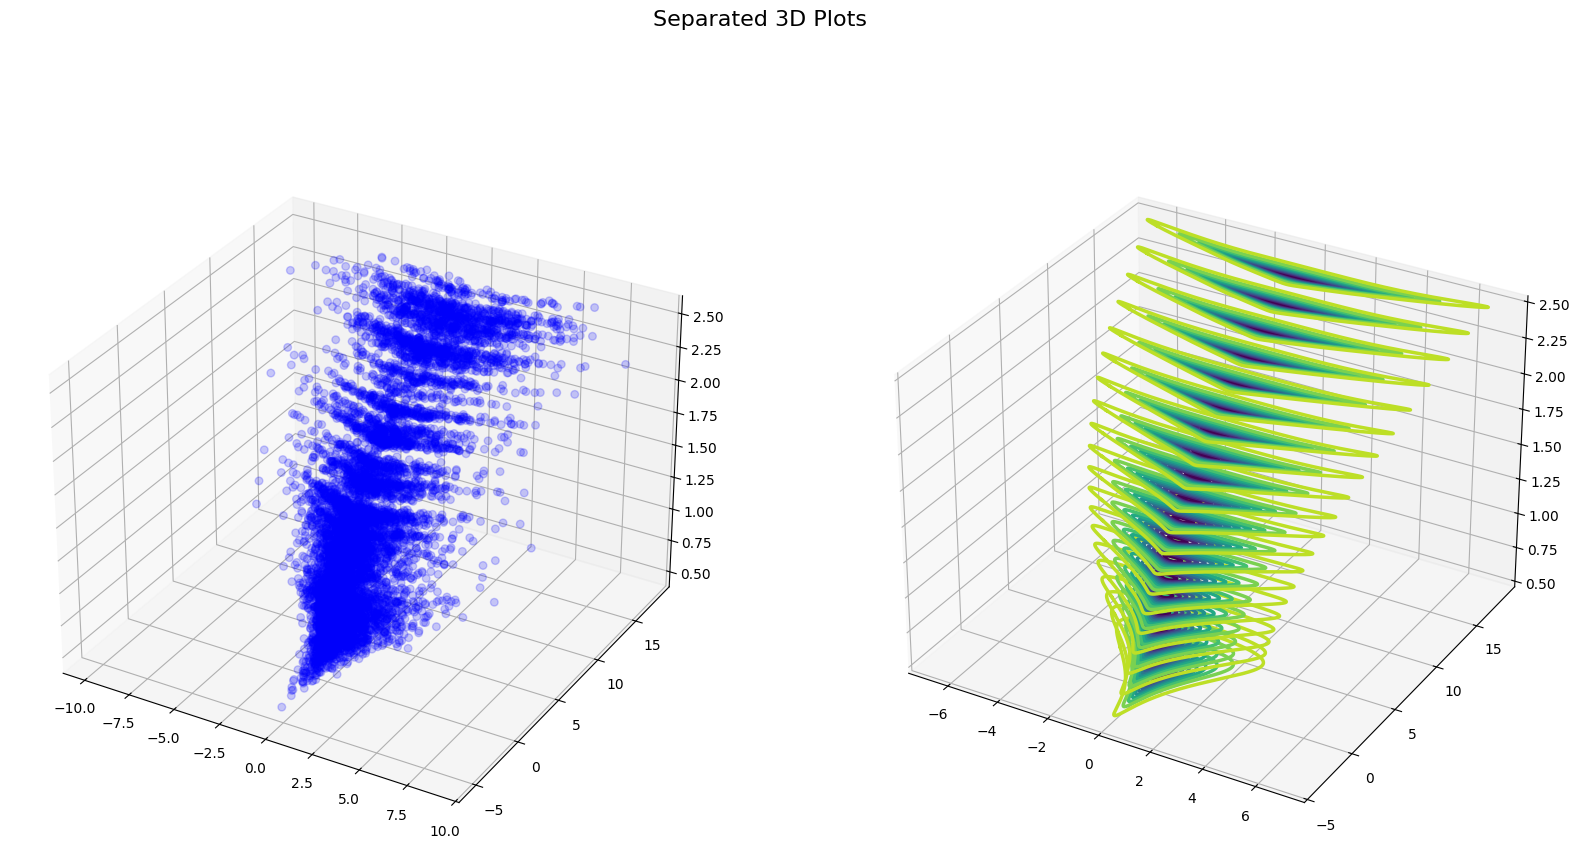

In [7]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from utils.quantile import get_quantile_level_analytically

number_of_conditions = 100
dataset_size = 100
x = torch.rand(1, number_of_conditions, 1) * 2 + 0.5
x = x.repeat(dataset_size, 1, 1)
u = torch.randn(dataset_size, number_of_conditions, 2).requires_grad_(True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), subplot_kw={'projection': '3d'})
fig.suptitle('Separated 3D Plots', fontsize=16)

u_potential = quadratic_potential(x=x, u=u)
y_ground_truth = torch.autograd.grad(u_potential.sum(), u)[0]
y_ground_truth_0 = y_ground_truth[:, :, 0].flatten()
y_ground_truth_1 = y_ground_truth[:, :, 1].flatten()
z = x.flatten()
ax1.scatter(y_ground_truth_0, y_ground_truth_1, z, color='blue', marker='o', s=30, alpha=0.2)

color_map = matplotlib.colormaps['viridis']
number_of_quantile_levels = 10
quantile_levels = torch.linspace(0.05, 0.95, number_of_quantile_levels)
radii = get_quantile_level_analytically(quantile_levels, distribution="gaussian", dimension=2)
colors = [color_map(i / len(radii)) for i in range(len(radii))]

for condition in torch.linspace(0.5, 2.5, 20):
    for i, contour_radius in enumerate(radii):
        color = colors[i]
        pi = torch.linspace(-torch.pi, torch.pi, 1000)

        u_quantile = torch.stack([
            contour_radius * torch.cos(pi),
            contour_radius * torch.sin(pi),
        ]).T
        u_quantile = u_quantile.to(**{}).requires_grad_(True)
        x_quantile = torch.ones(u_quantile.shape[0], 1)*condition

        u_quantile_potential = quadratic_potential(x=x_quantile, u=u_quantile)
        y_quantile = torch.autograd.grad(u_quantile_potential.sum(), u_quantile)[0]
        z_line = x_quantile.flatten()

        label = f'Quantile level {quantile_levels[i]:.2f}'
        ax2.plot(y_quantile[:, 0], y_quantile[:, 1], z_line, color=color, linewidth=2.5, label=label)

plt.show()